# Imports

In [2427]:
import json
import requests
import pandas as pd
from http import HTTPStatus
from matplotlib import pyplot as plt
from typing import Iterable, Dict, Union, List

# Activity 1

## 1.1 Sub-activity: Open Data COVID-19 API

### Task 1

In [2428]:
# The code for Task 1 is retrieved from https://coronavirus.data.gov.uk/details/developers-guide/main-api

StructureType = Dict[str, Union[dict, str]]
FiltersType = Iterable[str]
APIResponseType = Union[List[StructureType], str]

def get_API_data(filters:FiltersType , structure: StructureType) -> APIResponseType:
    # API URL
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"

    api_params = {
        "filters": "areaType=" + filters["areaType"],
        "structure": json.dumps(structure)
    }

    data = []
    page_number = 1
    
    while True:
        # Adding page number to query params
        api_params["page"] = page_number

        response = requests.get(endpoint, params=api_params)

        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f"Request failed: {response.text}")
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break

        current_data = response.json()
        
        # If there is no data in vaccination_age, set the value to None, otherwise the data will be an empty list
        for age in current_data["data"]:
            if not age["vaccination_age"]:
                age["vaccination_age"] = None

        page_data: List[StructureType] = current_data["data"]
       
        data.extend(page_data)

        # The "next" attribute in "pagination" will be `None`
        # when we reach the end.
        if current_data["pagination"]["next"] is None:
            break

        page_number += 1

    return data

### Task 2

In [2429]:
nation_filters = {"areaType":"nation"}
region_filters = {"areaType":"region"}

structure = {
    "date": "date",
    "name": "areaName",
    "daily_cases": "newCasesBySpecimenDate",
    "cumulative_cases": "cumCasesBySpecimenDate",
    "daily_deaths": "newDeaths28DaysByPublishDate",
    "cumulative_deaths": "cumDeaths28DaysByPublishDate",
    "cumulative_vaccinated": "cumPeopleVaccinatedSecondDoseByVaccinationDate",
    "vaccination_age": "vaccinationsAgeDemographics"
    }

results_json_national = get_API_data(nation_filters, structure)
results_json_regional = get_API_data(region_filters, structure)

## 1.2 Sub-activity: Shaping the COVID data into different dataframes

### Task 3

In [2430]:
# Concatenate the two lists of dictionaries
covid_data_list = results_json_national + results_json_regional

### Task 4

In [2431]:
# Convert the concatenated list of dictionaries to a pandas dataframe
covid_data = pd.DataFrame(covid_data_list)

### Task 5

In [2432]:
# Remove the rows with the value "England" in the dataframe
covid_data.drop(covid_data[covid_data["name"] == "England"].index, inplace=True)

### Task 6

In [2433]:
# Rename the column "name" to "area"
covid_data.rename(columns={"name": "area"}, inplace=True)

### Task 7

In [2434]:
# Convert the type of date column to datetime from string
covid_data["date"] = pd.to_datetime(covid_data["date"])

### Task 8

In [2435]:
# Since the vaccination_age will return a emtpy list if the data isn't available, 
# I set None to the empty list value. 
# Therefore, all the None values will be counted as missing data in the dataframe
nan = covid_data.isna().sum().sum()
print(covid_data.info())
print("\nThe amount of missing data is {}.".format(nan)) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12154 entries, 1044 to 13197
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   12154 non-null  datetime64[ns]
 1   area                   12154 non-null  object        
 2   daily_cases            12142 non-null  float64       
 3   cumulative_cases       12140 non-null  float64       
 4   daily_deaths           10179 non-null  float64       
 5   cumulative_deaths      10192 non-null  float64       
 6   cumulative_vaccinated  7305 non-null   float64       
 7   vaccination_age        7213 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 759.8+ KB
None

The amount of missing data is 13753.


### Task 9

In [2436]:
# Fill the missing data of each area with the value of the latest date that has values
covid_data["cumulative_cases"] = covid_data.groupby("area")["cumulative_cases"].fillna(method="bfill")
covid_data["cumulative_deaths"] = covid_data.groupby("area")["cumulative_deaths"].fillna(method="bfill")
covid_data["cumulative_vaccinated"] = covid_data.groupby("area")["cumulative_vaccinated"].fillna(method="bfill")


### Task 10

In [2437]:
# Drop the rows with missing data of cumulative metrics
if covid_data["cumulative_deaths"].isnull().sum() != 0:
    covid_data.drop(covid_data[covid_data["cumulative_deaths"].isnull() == True].index, inplace=True)
if covid_data["cumulative_cases"].isnull().sum() != 0:
    covid_data.drop(covid_data[covid_data["cumulative_cases"].isnull() == True].index, inplace=True)
if covid_data["cumulative_vaccinated"].isnull().sum() != 0:
    covid_data.drop(covid_data[covid_data["cumulative_vaccinated"].isnull() == True].index, inplace=True)

### Task 11

In [2438]:
# The code for rolling average by group of Task 11 is retrieved from https://stackoverflow.com/questions/31121344/sorting-pandas-dataframe-data-within-groupby-groups
# Fill the missing data of daily cases and deaths with 0
covid_data["daily_cases"].fillna(0, inplace=True)
covid_data["daily_deaths"].fillna(0, inplace=True)
# Create two new dataframes (7-day rolling average of new daily and death cases in each area)
daily_cases_roll_avg = covid_data.sort_values(["area","date"]).groupby("area")["daily_cases"].transform(lambda x: x.rolling(7).mean()).rename("daily_cases_roll_avg")
daily_deaths_roll_avg = covid_data.sort_values(["area","date"]).groupby("area")["daily_deaths"].transform(lambda x: x.rolling(7).mean()).rename("daily_deaths_roll_avg")
# Add the two new columns to the covid_data dataframe
covid_data = pd.concat([covid_data.sort_values(["area","date"]), daily_cases_roll_avg, daily_deaths_roll_avg], axis=1)

### Task 12

In [2439]:
# Drop daily_cases and daily_deaths columns
covid_data.drop(columns=["daily_cases", "daily_deaths"],inplace=True)

### Task 13

In [2440]:
# Create a new dataframe with the date, area, vaccination_age columns
covid_data_vaccinations = covid_data.loc[:,["date","area","vaccination_age"]]
# Drop the vaccination_age from the covid_data dataframe
covid_data.drop(columns=["vaccination_age"],inplace=True)

### Task 14

In [2441]:
# Explode the dictionaries that are inside of the vaccination_age list for each row
exploded = pd.DataFrame(covid_data_vaccinations.explode("vaccination_age", ignore_index=True))

# Since the dictionaries are exploded and the dictionaries are in JSON format, 
# then use the json_normalize function to convert the dictionaries to columns
normalized = pd.json_normalize(exploded["vaccination_age"])

# Concatenate the exploded and normalized dataframes
covid_data_vaccinations_wide = pd.concat([exploded, normalized], axis=1)

# Drop redundant columns
covid_data_vaccinations_wide.drop(columns=[
    "vaccination_age",
    "cumPeopleVaccinatedThirdInjectionByVaccinationDate",
    "newPeopleVaccinatedThirdInjectionByVaccinationDate",
    "cumVaccinationThirdInjectionUptakeByVaccinationDatePercentage",
    "cumPeopleVaccinatedAutumn22ByVaccinationDate",
    "cumPeopleVaccinatedSpring22ByVaccinationDate",
    "newPeopleVaccinatedAutumn22ByVaccinationDate",
    "newPeopleVaccinatedSpring22ByVaccinationDate",
    "cumVaccinationAutumn22UptakeByVaccinationDatePercentage",
    "cumVaccinationSpring22UptakeByVaccinationDatePercentage"
    ], inplace=True)

## 1.3 Sub-activity: Aggregating, plotting, and analysing

### Task 15

' \nAnswer to Task 15\nWe can see from the plot that the cumulative cases in London \nhas been increasing since the beginning of the pandemic, while\nthere are two plateaus in the plot. The first plateau is from\nthe end of January to july in 2021, and the second plateau\nis from the beginning of April to the end of the year (slightly increased). \n'

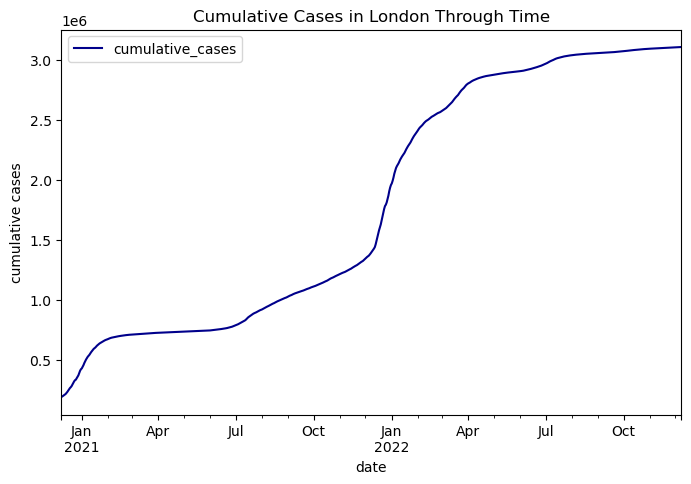

In [2442]:
# Intermediate dataframe
cumulative_cases_in_London_through_time = covid_data.loc[covid_data["area"] == "London", ["date", "cumulative_cases"]]

# Plot to intermediate dataframe
cumulative_cases_in_London_through_time.plot(x = "date", y = "cumulative_cases", figsize = (8,5), ylabel = "cumulative cases", title = "Cumulative Cases in London Through Time", color = "darkblue")

""" 
Answer to Task 15
We can see from the plot that the cumulative cases in London 
has been increasing since the beginning of the pandemic, while
there are two plateaus in the plot. The first plateau is from
the end of January to july in 2021, and the second plateau
is from the beginning of April to the end of the year (slightly increased). 
"""

### Task 16

           date              area  cumulative_cases  cumulative_deaths  \
0    2021-01-03  Northern Ireland           77833.0             1354.0   
1    2021-01-04  Northern Ireland           79843.0             1366.0   
2    2021-01-05  Northern Ireland           81441.0             1384.0   
3    2021-01-06  Northern Ireland           82930.0             1397.0   
4    2021-01-07  Northern Ireland           84117.0             1414.0   
...         ...               ...               ...                ...   
1066        NaT               NaN               NaN                NaN   
1067        NaT               NaN               NaN                NaN   
1068        NaT               NaN               NaN                NaN   
1069        NaT               NaN               NaN                NaN   
1070        NaT               NaN               NaN                NaN   

      cumulative_vaccinated  daily_cases_roll_avg  daily_deaths_roll_avg  \
0                    1271.0        

'\nAnswer to Task 16\nWe can see from the plot that the cumulative cases in all areas\nis almost the same as the cumulative cases in London. Whereas \n'

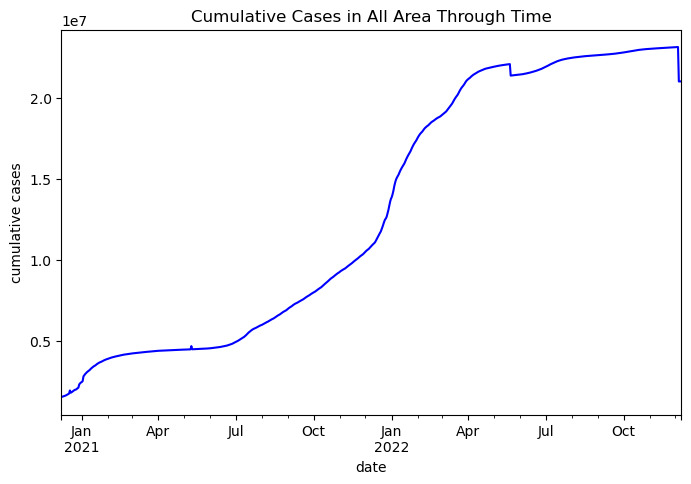

In [2458]:
# Intermediate dataframe
# Add more date to the Northern Ireland from 2021/5/20 to 2022/12/8
Northern_Ireland = covid_data[covid_data["area"] == "Northern Ireland"]
# Create a new dataframe with the date range from 2021/5/20 to 2022/12/8
date_range = pd.DataFrame(pd.date_range(start="2021-05-20", end="2022-12-08"))
# Add new date to the Northern Ireland dataframe
Northern_Ireland_with_new_date = pd.concat([Northern_Ireland, date_range], ignore_index = True)
print(Northern_Ireland_with_new_date)
# Fill the empty data of cumulative cases from 2021/5/20 to 2022/12/8 in Northern Ireland by 2021/5/20's value
Northern_Ireland_with_new_date["cumulative_cases"].ffill(inplace = True)
Northern_Ireland_with_new_date["area"].ffill(inplace = True)
# Drop the data of Northern Ireland from the covid_data dataframe
covid_data_drop_Northern_Ireland = covid_data[covid_data["area"] != "Northern Ireland"]
# Add back Northern Ireland with new date to the covid_data dataframe
covid_data_with_new_Northern_Ireland_data = pd.concat([covid_data_drop_Northern_Ireland, Northern_Ireland_with_new_date])
print(covid_data_with_new_Northern_Ireland_data.tail(10))

cumulative_cases_summed_over_all_areas = covid_data_with_new_Northern_Ireland_data.groupby("date")["cumulative_cases"].sum()

# Plot to intermediate dataframe
cumulative_cases_summed_over_all_areas.plot(figsize = (8,5), ylabel = "cumulative cases", title = "Cumulative Cases in All Area Through Time", color = "blue")

"""
Answer to Task 16
We can see from the plot that the cumulative cases in all areas
is almost the same as the cumulative cases in London. Whereas 
"""

### Task 17

<AxesSubplot:xlabel='date'>

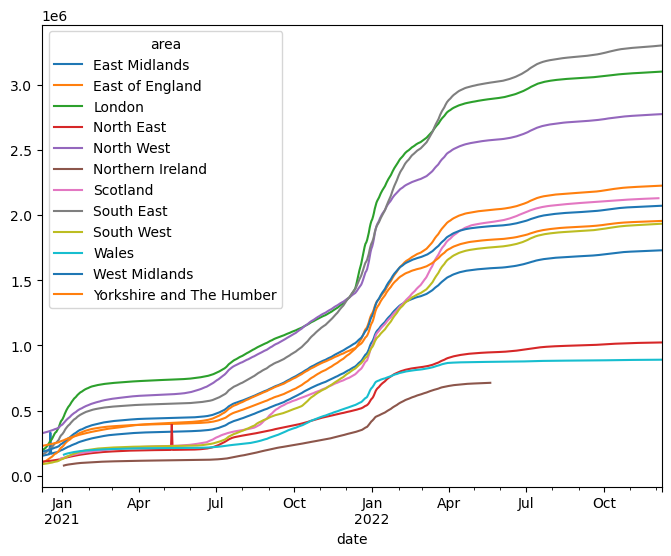

In [2444]:
cumulative_cases_of_different_areas = covid_data.groupby(["date","area"])["cumulative_cases"].sum().unstack()
cumulative_cases_of_different_areas.plot(figsize=(8, 6))

### Task 18

### Task 19

<AxesSubplot:xlabel='date'>

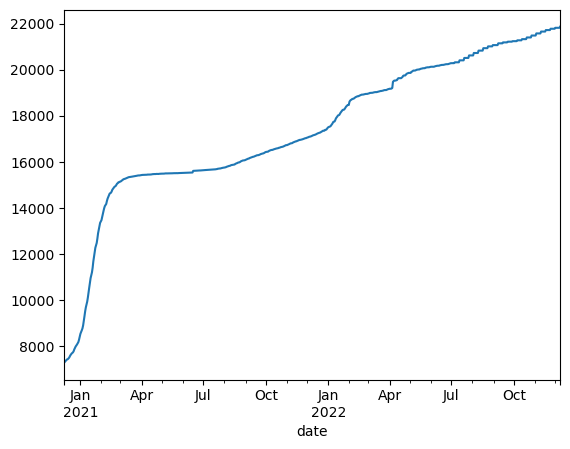

In [2445]:
evolution_of_cumulative_deaths_in_London = covid_data[covid_data["area"] == "London"].groupby("date")["cumulative_deaths"].sum()
evolution_of_cumulative_deaths_in_London.plot()

### Task 20

### Task 21

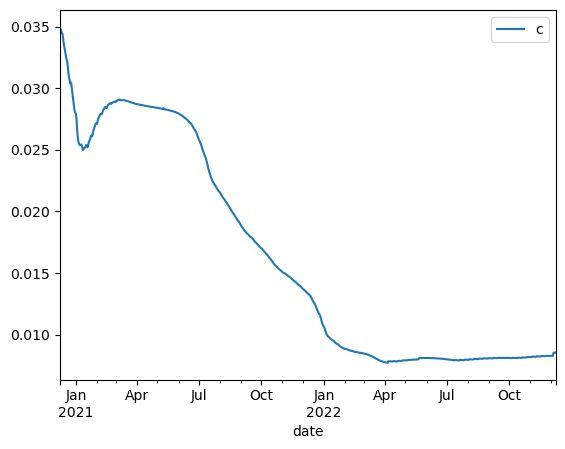

In [2446]:
cumulative_deaths_per_cases = covid_data.groupby(["date"])["cumulative_deaths"].sum() / covid_data.groupby("date")["cumulative_cases"].sum()

cumulative_deaths_per_cases.plot()
plt.legend("cumulative_deaths_per_cases")

### Task 22

### Task 23

<AxesSubplot:xlabel='date'>

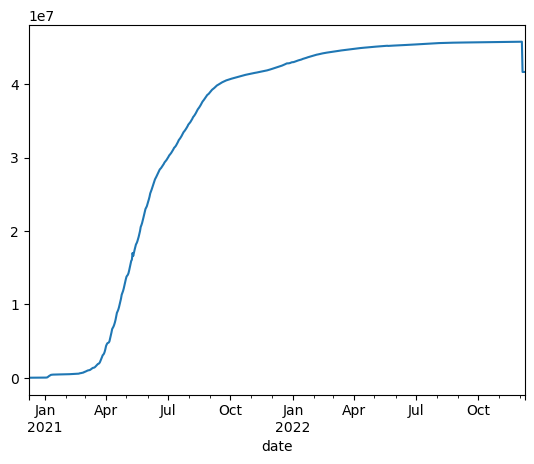

In [2447]:
sum_of_cumulative_vaccinations_over_all_areas = covid_data.groupby("date")["cumulative_vaccinated"].sum()
sum_of_cumulative_vaccinations_over_all_areas.plot()

### Task 24

<AxesSubplot:xlabel='date'>

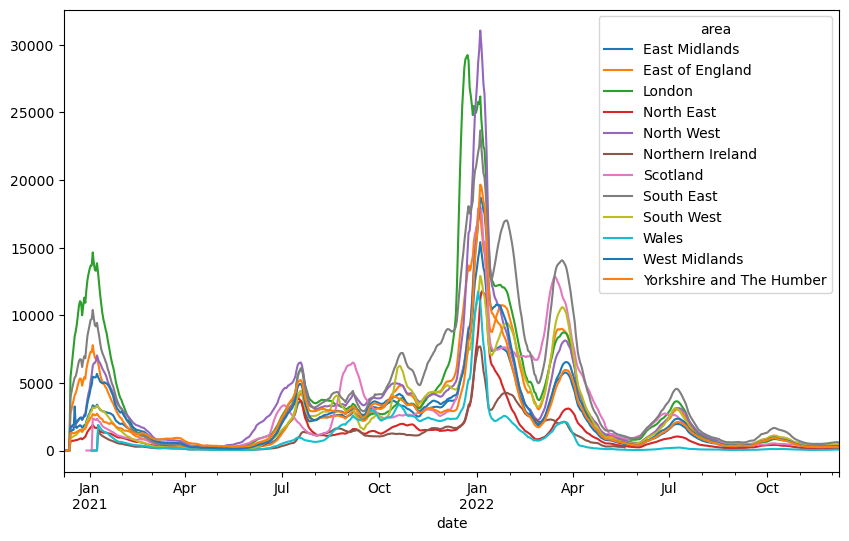

In [2448]:
daily_cases_rolling_average_separated_by_areas = covid_data.groupby(["date","area"])["daily_cases_roll_avg"].sum().unstack()
daily_cases_rolling_average_separated_by_areas.plot(figsize=(10, 6))

### Task 25

### Task 26

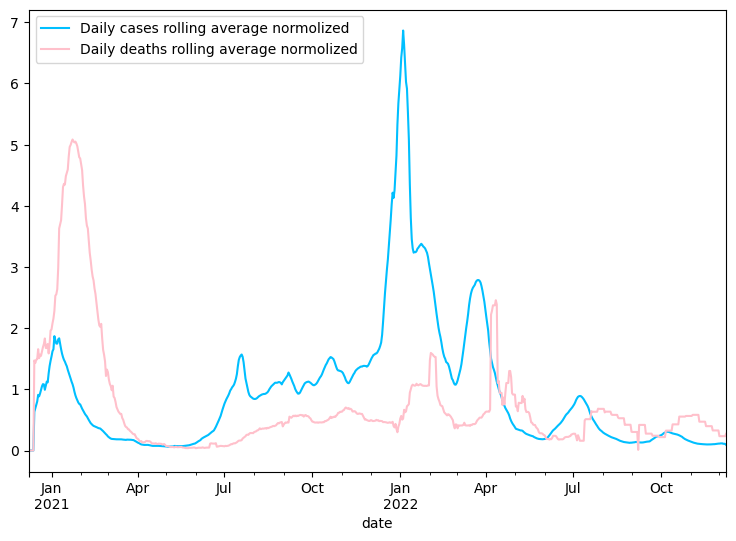

In [2449]:
covid_data["daily_cases_roll_avg_norm"] = covid_data["daily_cases_roll_avg"] / covid_data["daily_cases_roll_avg"].max()
covid_data["daily_deaths_roll_avg_norm"] = covid_data["daily_deaths_roll_avg"] / covid_data["daily_deaths_roll_avg"].max()
covid_data.groupby("date")["daily_cases_roll_avg_norm"].sum().plot(figsize=(9, 6), color = "deepskyblue")
covid_data.groupby("date")["daily_deaths_roll_avg_norm"].sum().plot(figsize=(9, 6), color = "pink")
plt.legend(["Daily cases rolling average normolized", "Daily deaths rolling average normolized"])

### Task 27

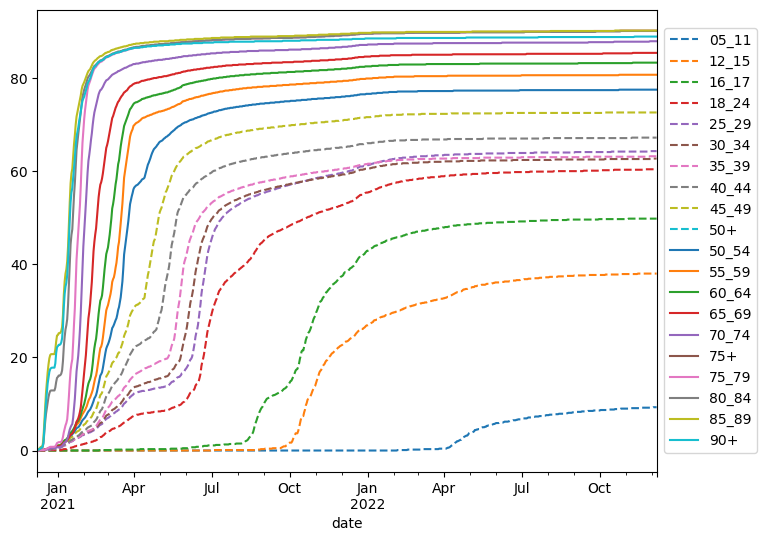

In [2450]:
covid_data_vaccinations_wide_london = covid_data_vaccinations_wide[covid_data_vaccinations_wide["area"] == "London"]
covid_data_vaccinations_wide_scotland = covid_data_vaccinations_wide[covid_data_vaccinations_wide["area"] == "Scotland"]

covid_data_vaccinations_wide_london = covid_data_vaccinations_wide_london[["date", "age", "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage"]]
columns = covid_data_vaccinations_wide_london.groupby('date')['age'].apply(list)[0]
covid_data_vaccinations_wide_london = covid_data_vaccinations_wide_london.groupby('date')['cumVaccinationFirstDoseUptakeByVaccinationDatePercentage'].apply(list).apply(pd.Series)
covid_data_vaccinations_wide_london.columns=columns
covid_data_vaccinations_wide_london.reset_index(inplace=True)

covid_data_vaccinations_wide_london.plot(figsize=(8, 6), x="date", y=columns, style=["--" for _ in range(10)])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Task 28

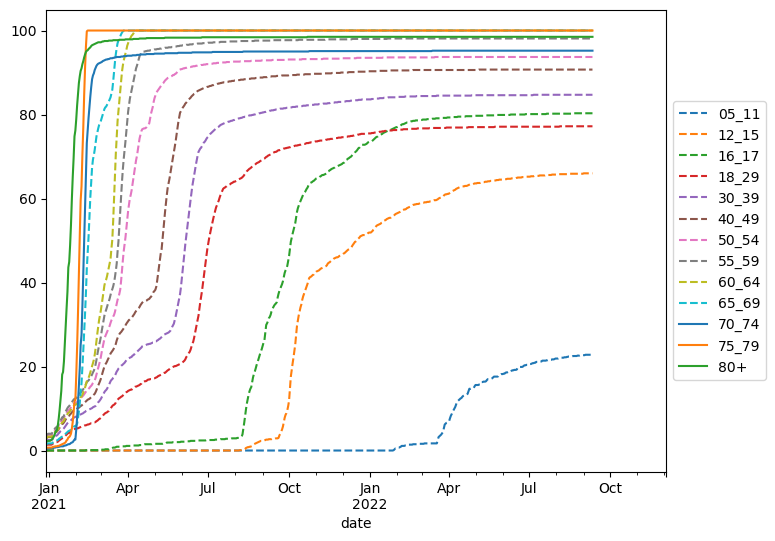

In [2451]:
covid_data_vaccinations_wide_scotland = covid_data_vaccinations_wide_scotland[["date", "age", "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage"]]
columns = covid_data_vaccinations_wide_scotland.groupby('date')['age'].apply(list)[0]
covid_data_vaccinations_wide_scotland = covid_data_vaccinations_wide_scotland.groupby('date')['cumVaccinationFirstDoseUptakeByVaccinationDatePercentage'].apply(list).apply(pd.Series)
covid_data_vaccinations_wide_scotland.columns=columns
covid_data_vaccinations_wide_scotland.reset_index(inplace=True)

covid_data_vaccinations_wide_scotland.plot(figsize=(8, 6), x="date", y=columns, style=["--" for _ in range(10)])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))